## Data Exploration

In [1]:
# Extension reloader to import a function again when re-running cell 
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from datetime import datetime
program_start_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print('Started: '+ program_start_time)

Started: 2020-05-20_09-15-49


### Load configuration

In [4]:
"""
Loads common configuration parameters
"""
from src.utils.configuration_manager import Config
from pathlib import Path, PurePath
from os import getcwd

config_path = PurePath(getcwd(),'config.ini')
config = Config(config_path)

Loading configuration from: /home/justin/Code/interpretability_experiment/config.ini


### Figures subdirectory

In [5]:
figures_dir = Path(config.figures_dir, 'data_exploration')
figures_dir.mkdir(parents=True, exist_ok=True)

### Start local Dask Client

In [6]:
from dask.distributed import Client, LocalCluster
try:
    if client:
        print('Restarting client')
        client.restart()
except:
    cluster = LocalCluster(dashboard_address=':20100', memory_limit='5G')
#     cluster = LocalCluster(dashboard_address=':20100')
    print('Setting new client')
    client = Client(cluster)
    print(client)
client

Setting new client
<Client: 'tcp://127.0.0.1:40571' processes=5 threads=10, memory=25.00 GB>


Client Scheduler: tcp://127.0.0.1:40571 Dashboard: http://127.0.0.1:20100/status,Cluster Workers: 5 Cores: 10 Memory: 25.00 GB


### Prepare Dataset

In [7]:
"""
Loads the dataset file based on configuration 
"""
from src.preprocessing.dataset_manager import DatasetManager
dataset_manager = DatasetManager(config)

In [8]:
%time dataset_manager.write_dataset(overwrite=False)

Not overwriting existing training and test sets
CPU times: user 0 ns, sys: 599 µs, total: 599 µs
Wall time: 3.14 ms


In [9]:
ddf = dataset_manager.load_ddf()

In [10]:
ddf.npartitions

326

In [11]:
# ddf = ddf.repartition(npartitions=10000)

## Basic Data Statistics

In [12]:
ddf.dtypes

VendorID                       category
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                     category
PULocationID                   category
DOLocationID                   category
payment_type                   category
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount_wo_tip             float64
tip_fraction                    float64
tipped                             bool
dtype: object

In [13]:
# %time ddf.describe().compute()

### Add OHE for payment type

In [14]:
from dask_ml.preprocessing import OneHotEncoder

# init encoder
encoder = OneHotEncoder(sparse=False)

# Transform categories for Dask, don't have enough hard drive space to handle a full OHE
# categorical_columns = ddf.select_dtypes(['category']).columns
categorical_columns = ['payment_type']
ddf[categorical_columns] = ddf[categorical_columns].categorize()

%time encoder.fit(ddf[categorical_columns])

CPU times: user 2.05 ms, sys: 297 µs, total: 2.35 ms
Wall time: 1.97 ms


OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [15]:
# Transform to OHE
%time ddf_temp = encoder.transform(ddf[categorical_columns])

CPU times: user 6.51 ms, sys: 0 ns, total: 6.51 ms
Wall time: 6.35 ms


In [16]:
import dask.dataframe as dd
ddf = dd.concat([ddf, ddf_temp], axis=1)

/home/justin/.conda/envs/ml_env/lib/python3.7/site-packages/dask/dataframe/multi.py:1094: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


In [17]:
# Ignoring the warning message for now, the indices are the same in this case
%time correlations = ddf.corr().compute()

CPU times: user 18.7 s, sys: 2.68 s, total: 21.4 s
Wall time: 2min 56s


In [18]:
def prt_corr(correlations, targets):
    """
    Prints the correlations, ignoring correlations between target variables
    """
    for target in targets:
        print()
        inputs = [x for x in correlations.index if not x in config.targets]

        corr_temp = correlations[target][inputs]
        print(corr_temp)
    
prt_corr(correlations, config.targets)


passenger_count         -0.003554
trip_distance            0.113030
fare_amount              0.045267
extra                    0.076791
mta_tax                 -0.091437
tolls_amount             0.389426
improvement_surcharge    0.000342
total_amount_wo_tip      0.050178
payment_type_1           0.476373
payment_type_2          -0.468886
payment_type_3          -0.051849
payment_type_4          -0.027792
payment_type_5           0.000134
Name: tip_amount, dtype: float64

passenger_count         -0.002685
trip_distance            0.000392
fare_amount             -0.000354
extra                    0.000783
mta_tax                 -0.014493
tolls_amount             0.002404
improvement_surcharge    0.000096
total_amount_wo_tip     -0.000326
payment_type_1           0.122390
payment_type_2          -0.120488
payment_type_3          -0.013247
payment_type_4          -0.007024
payment_type_5          -0.000009
Name: tip_fraction, dtype: float64

passenger_count         -0.019394
trip_distan

## Explore Tipping Distributions

Let's start by looking at the distribution of tipping behavior

In [19]:
import dask.array as da
import numpy as np
bin_count = 50

In [20]:
def get_hist_bins(ddf, target, bin_count, range_lst):
    """
    Gets bins and histogram arrays using Dask engine
    """
    number_of_sample = len(ddf)
    h, bins = da.histogram(ddf[target], bins=bin_count, range=range_lst)
    hist_values = h.compute()
    return bins, hist_values/number_of_sample

def write_figure(target, bins, hist, write_to):
    """
    Creates a figure from bins and histogram values
    """
    # For spacing between bins
    x = 0.5 * (bins[1:] + bins[:-1])
    width = np.diff(bins)
    
    plt.ylabel('Relative Frequency')
    plt.xlabel(target)
    plt.title(target + ' distribution')
    plt.bar(x, hist, width)
    plt.savefig(write_to)

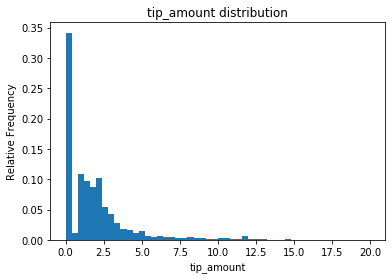

In [21]:
target = 'tip_amount'
writing_path = Path(figures_dir, 'tip_amount_density_bar')
bins, hist = get_hist_bins(ddf, target, bin_count=bin_count, range_lst=[0,20])
write_figure(target, bins, hist, writing_path)

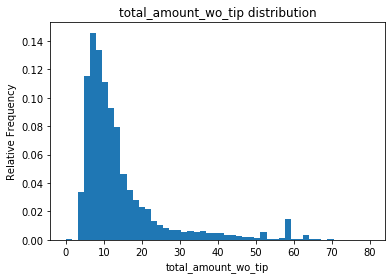

In [22]:
target = 'total_amount_wo_tip'
writing_path = Path(figures_dir, 'total_amount_wo_tip_density_bar')
bins, hist = get_hist_bins(ddf, target, bin_count=bin_count, range_lst=[0,80])
write_figure(target, bins, hist, writing_path)

These have similar distributions, perhaps there is some threshold point at which people feel more obliged to tip. There may be more signal in tip fraction

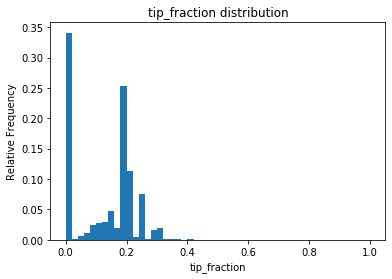

In [23]:
target = 'tip_fraction'
writing_path = Path(figures_dir, 'tip_fraction_density_bar')
bins, hist = get_hist_bins(ddf, target, bin_count=bin_count, range_lst=[0,1])
write_figure(target, bins, hist, writing_path)

Seems that the majority of riders will either tip around 20% to the driver, or not at all. Perhaps this is a reporting issue with payment types though - where credit card payments are not being recorded.  

## Tip by location

In [24]:
# We'll use tip fraction here since it seems to give a better signal than tip amount
tip = 'tip_fraction'

In [85]:
pu_location = 'PULocationID'
tip_by_pu_loc_res = ddf.groupby(pu_location).agg({tip: ['mean', 'std', 'count'],
                                               'trip_distance': ['mean'], 
                                               'fare_amount': ['mean']}).compute()

In [86]:
print(tip_by_pu_loc_res.sort_values((tip, 'mean'), ascending=False)[:20])

             tip_fraction                   trip_distance fare_amount
                     mean        std  count          mean        mean
PULocationID                                                         
30              17.335462  62.257281     27     10.200370   20.751852
109              8.542717  44.811353     57      5.882456   47.604737
154              1.501598  27.662754    381     13.587690   52.697375
94               1.434918  46.610920   1150      4.730722   19.920122
44               1.337546   5.954951     42     15.245238   48.561905
265              1.142580  20.006365  53916      3.101143   70.363637
1                0.906380  13.696299   8513      2.004142   76.694931
253              0.898734  13.852365    348      9.352989   40.566667
208              0.851021  23.816183   1775      8.201792   31.373504
117              0.544585   9.700321    680     14.898324   55.749368
5                0.425196   3.244145    135     19.268519   71.134148
201              0.2

In [80]:
do_location = 'DOLocationID'
tip_by_do_loc_res = ddf.groupby(do_location).agg({tip: ['mean', 'std', 'count'],
                                               'trip_distance': ['mean'], 
                                               'fare_amount': ['mean']}).compute()

In [83]:
print(tip_by_do_loc_res.sort_values((tip, 'mean'), ascending=False)[:20])

             tip_fraction                     trip_distance fare_amount
                     mean        std    count          mean        mean
DOLocationID                                                           
30               1.337177  17.033909      374     14.448155   41.545401
109              0.527996  10.087923     1144     22.740358   66.273750
265              0.444751  11.173953   266434     14.643916   74.994107
115              0.368833  11.095051     1774     17.836353   51.646578
94               0.227437  16.954103     8703      9.761202   31.376359
1                0.185763   3.780659   211946     17.258683   71.875257
199              0.166051   0.154611       20      3.897500   13.800000
138              0.165014   0.732902  1243742     10.066921   32.660940
40               0.160513   0.402690   125259      6.767021   23.132462
52               0.158929   0.173198    92269      6.179111   21.651485
189              0.154620   0.232280   112251      6.747661   24

In [87]:
tip_by_pu_loc_res.corr()

tip_fraction                     trip_distance fare_amount
                            mean       std     count          mean        mean
tip_fraction  mean      1.000000  0.813697 -0.033755      0.092218    0.074273
              std       0.813697  1.000000 -0.096713      0.143066    0.223976
              count    -0.033755 -0.096713  1.000000     -0.391942   -0.340333
trip_distance mean      0.092218  0.143066 -0.391942      1.000000    0.760719
fare_amount   mean      0.074273  0.223976 -0.340333      0.760719    1.000000

Trip distance correlates highly with fare_amount, as you might expect, but doesn't associate with tip fraction. 

Pick up location seems to be a more important factor for high tips. While small samples make me doubt the importance of PULocation in the top tip_fraction cases, it seems like PuLocation265 could be a good place for taxi drivers to hangout if they want to increase their tips. 

## Seasonal trends

### Tips by day of the week

In [94]:
# Using picking time as the timestamp
ts = 'tpep_pickup_datetime'

In [95]:
%time day_of_week_tips = ddf.groupby([ddf[ts].dt.dayofweek]).agg({tip: ['mean', 'std', 'count']}).compute()

CPU times: user 3.31 s, sys: 346 ms, total: 3.65 s
Wall time: 26.9 s


In [96]:
days_dict = {'Monday':0, 
             'Tuesday':1, 
             'Wednesday':2, 
             'Thursday':3, 
             'Friday':4, 
             'Saturday': 5, 
             'Sunday':6}

In [97]:
index_map = {y:x for x, y in days_dict.items()}
day_of_week_tips.index = day_of_week_tips.index.map(index_map)

In [131]:
# TODO - is it reasonable that a std is so high? Will use the standard error for now
import math
print(day_of_week_tips)

                     tip_fraction                              
                             mean       std     count        se
tpep_pickup_datetime                                           
Monday                   0.131513  0.795732  14879162  0.000206
Tuesday                  0.134655  0.622968  15986547  0.000156
Wednesday                0.135222  0.769716  16182062  0.000191
Thursday                 0.135341  0.677671  17174383  0.000164
Friday                   0.131413  0.745635  17334732  0.000179
Saturday                 0.124838  0.717446  16550357  0.000176
Sunday                   0.126649  0.636842  14127383  0.000169


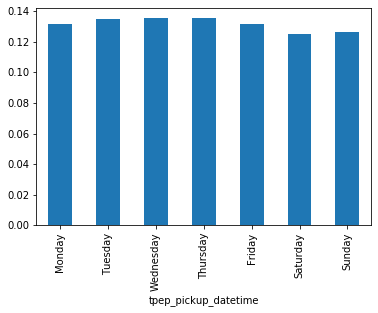

In [112]:
# import matplotlib.pyplot as plt
bar_plt = day_of_week_tips[(tip,'mean')].plot.bar()

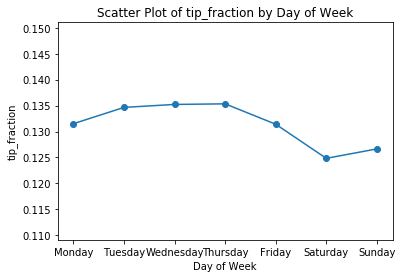

In [156]:
def plot_scatter(result_df, target, x_label, write_to):
    """
    Plot the timeframe results in a scatter plot, showing standard error for the sample
    """
    plt.scatter(result_df.index, 
            result_df[(target,'mean')])
    
    # Get standard error from standard deviation - this seems to largely dissapear based on large sample size
    result_df[(tip, 'se')] = result_df[(tip, 'std')] \
                                    / (result_df[(tip, 'count')].apply(lambda x: math.sqrt(x)))
    plt.errorbar(result_df.index, 
                 result_df[(target,'mean')],
                 result_df[(target,'se')])
    
    plt.xlabel(x_label)
    plt.ylabel(target)
    plt.title('Scatter Plot of ' + target + ' by '+ x_label)
    plt.savefig(write_to)
    

In [ ]:
writing_path = Path(figures_dir, 'scatter_tip_fraction_by_day')
plot_scatter(day_of_week_tips, tip, 'Day of Week', writing_path)

There appears to be lower tips over the weekend. It would be interesting to compare what other factors might affect reported tips on that day

In [122]:
hour_of_day_tips = ddf.groupby([ddf[ts].dt.hour]).agg({tip: ['mean', 'std', 'count']}).compute()

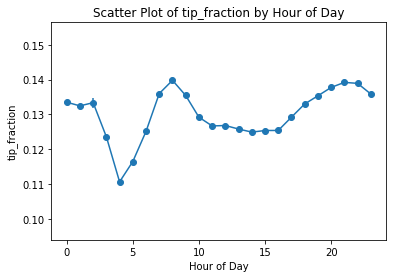

In [157]:
writing_path = Path(figures_dir, 'scatter_tip_fraction_by_hour')
plot_scatter(hour_of_day_tips, tip, 'Hour of Day', writing_path)

There appears to be a decrease in the tip fraction over time of day, with a deep dip in the early morning, and spike in rush-hour commuting hours into the early evening. Will need to compare this to payment type. 

### Hourly trends during the week relative to Saturday and Sunday

In [133]:
%time saturday_tips = ddf.groupby([ddf[ts].dt.dayofweek == 5]).agg({tip: ['mean', 'std', 'count']}).compute()

CPU times: user 3.32 s, sys: 335 ms, total: 3.65 s
Wall time: 24.5 s


In [134]:
print(saturday_tips)

                     tip_fraction                    
                             mean       std     count
tpep_pickup_datetime                                 
False                    0.132616  0.711717  95684269
True                     0.124838  0.717446  16550357


Let's look at tiping behavior over the course of the year, averaging result by day

In [159]:
# %time day_mean_tips = ddf.groupby([ddf[ts].dt.date])[tip].mean().compute()

In [160]:
# print(day_mean_tips)

In [161]:
"""
Cleanup and plot result
"""
day_mean_tips.sort_index(inplace=True)

In [162]:
import pandas as pd
# Transform indices back to datetime objects for filtering
# day_mean_tips.index = pd.to_datetime(day_mean_tips.index.to_series())
# results = {index: row for index, row in day_mean_tips.iteritems() if index.year == 2018}

In [163]:
# filtered_day_mean_tips = day_mean_tips[day_mean_tips.index.year == 2018]
# filtered_day_mean_tips.plot()

#### Aggregate by week

In [164]:
%time weekly_mean_tips = filtered_day_mean_tips.groupby([filtered_day_mean_tips.index.to_series().dt.week]).mean()

CPU times: user 3.03 ms, sys: 0 ns, total: 3.03 ms
Wall time: 2.52 ms


(52,)


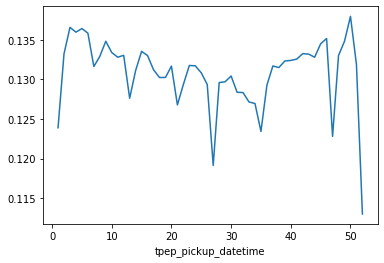

In [165]:
print(weekly_mean_tips.shape)
weekly_mean_tips.plot()

#### Aggregate by month

In [166]:
%time monthly_mean_tips = filtered_day_mean_tips.groupby([filtered_day_mean_tips.index.to_series().dt.month]).mean()

CPU times: user 2.5 ms, sys: 347 µs, total: 2.84 ms
Wall time: 2.5 ms


(12,)


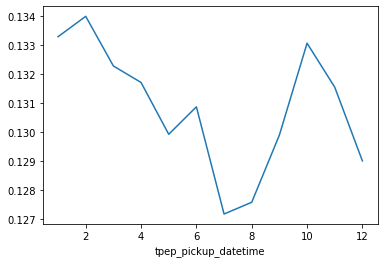

In [167]:
print(monthly_mean_tips.shape)
monthly_mean_tips.plot()

Seems there is some cyclicality to tipping (e.g., a spike in the fall/early winter months).